# Baseline Models for Skin Classification Using Traditional Machine Learning Methods 

William Chen, Gokul Srinivasan, Avani Kuthe, XingJian Diao

COSC 89.2 Data Science for Health

Oct. 2022

In [1]:
import pandas as pd
import numpy as np 
import skimage as skmg
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math 
from tqdm import tqdm
from random import *
from PIL import Image
import os
import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
#from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import *
from sklearn.neighbors import KNeighborsClassifier
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from skimage.util import random_noise
from scipy.stats import uniform

## Data Ingestion and Preprocessing

In [2]:
# Get the metadata and diagnoses
df = pd.read_csv("./HAM10000/HAM10000_metadata.csv")
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [3]:
# Label encoder for diagnoses
lb = LabelEncoder()
lb.fit_transform(df['dx'])
cls2lbl = {cls: idx for idx, cls in enumerate(lb.classes_)}
lbl2cls = {idx: cls for idx, cls in enumerate(lb.classes_)}
df['label'] = [cls2lbl[cls] for cls in df['dx']]

In [169]:
cls2lbl

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [21]:
# Read in images 
sds = ["./HAM10000/HAM10000_images_part_1/", "./HAM10000/HAM10000_images_part_2/"]
dir = "HAM10000/HAM10000_segmentations_lesion_tschandl/HAM10000_segmentations_lesion_tschandl/"
imgs = []

# Get the images, downsized by factor of 2
for sd in sds:
    filelist = [f for f in os.listdir(sd)]
    for file in tqdm(filelist):
        imgs.append(rescale(mpimg.imread(sd+file), 0.25, multichannel=True))

100%|██████████| 5015/5015 [02:38<00:00, 31.62it/s]


In [49]:
# Read in external test set
#test_imgs = []
#testdir = "./HAM10000/ISIC2018_Task3_Test_Images/ISIC2018_Task3_Test_Images/"
#testlist = [f for f in os.listdir(testdir)]   
#for f in tqdm(testlist):
    #test_imgs.append(mpimg.imread(testdir+f))

100%|██████████| 1511/1511 [00:15<00:00, 96.42it/s] 


In [22]:
# Get segmentation masks  
masks = []
masklist = [f for f in os.listdir(dir)]   
for f in tqdm(masklist):
    m = mpimg.imread(dir+f)
    if m.ndim>2:
        masks.append(rescale(m[:,:,0], 0.25))
    else:
        masks.append(rescale(m, 0.25))

100%|██████████| 10015/10015 [01:45<00:00, 95.36it/s] 


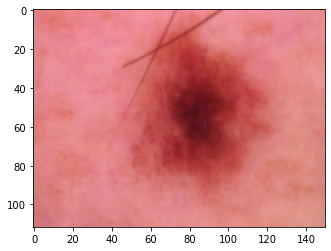

In [23]:
plt.imshow(imgs[0])

In [88]:
seg_imgs = []
for c, img in tqdm(enumerate(imgs)):
    new_img = img
    for d in range(3):
        new_img[:,:,d] = np.multiply(img[:,:,d], masks[c])
    seg_imgs.append(new_img)
#plt.imshow(new_img)

10015it [00:06, 1500.36it/s]


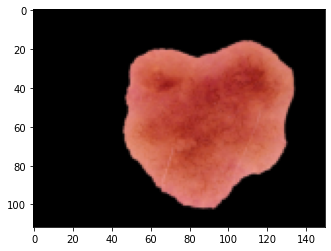

In [93]:
plt.imshow(seg_imgs[789])

In [103]:
df["seg_img"] = seg_imgs

In [105]:
df["dx"].value_counts()
# Severe data imbalance

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [121]:
str(6705/10015*100)+" % of instances are melanocytic nevi"

'66.94957563654518 % of instances are melanocytic nevi'

In [113]:
other_df = df[df["dx"] != "nv"]
other_df["dx"].value_counts() # Removing all instances of nv, get 3310 instances of other

mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [114]:
other_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,seg_img
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


In [94]:
# Generate a new image by randomly transforming an existing one 
def augment_image(img):
    aug_img = img
    # Random flips 
    if random()<=0.5: 
        aug_img = np.fliplr(aug_img)
    if random()<=0.5:
        aug_img = np.flipud(aug_img)
    aug_img = skmg.transform.rotate(aug_img, angle=random()*360, mode = 'edge') # Random rotation
    #aug_img = skmg.util.random_noise(aug_img)
    return aug_img

In [115]:
# Generate an augmented image for each instance of class other than "nv"
other_df["aug_img"] = [augment_image(n) for n in other_df["seg_img"]]

C:\Users\wchen\AppData\Local\Temp/ipykernel_24028/405106391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df["aug_img"] = [augment_image(n) for n in other_df["seg_img"]]


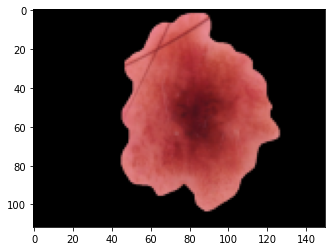

In [117]:
plt.imshow(other_df["seg_img"][0])

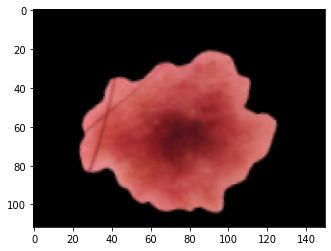

In [118]:
plt.imshow(other_df["aug_img"][0])

In [119]:
nv_df = df[df["dx"] == "nv"].sample(n=2227)

In [128]:
str(2227/6705*100)+" % of nv samples are used"

'33.21401938851603 % of nv samples are used'

In [122]:
nv_df.head(1)

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,seg_img
7485,HAM_0005383,ISIC_0032893,nv,histo,40.0,female,back,5,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


In [123]:
final_imgs = nv_df["seg_img"].tolist()+other_df["seg_img"].tolist()+other_df["aug_img"].tolist()
final_lbls = nv_df["label"].tolist()+other_df["label"].tolist()+other_df["label"].tolist()

In [125]:
len(final_imgs)
len(final_lbls)

8847

In [133]:
# Perform train test split
x_train, x_test, y_train, y_test = train_test_split(final_imgs, final_lbls, test_size=0.2, stratify = final_lbls)

In [136]:
def rescale_channels(channel):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(channel)
    return scaler, scaled_data

In [137]:
# Flatten and normalize training images 
rscaler, r_channel_train = rescale_channels([x_train[n][:,:,0].flatten() for n in tqdm(range(len(x_train)))])
gscaler, g_channel_train = rescale_channels([x_train[n][:,:,1].flatten() for n in tqdm(range(len(x_train)))])
bscaler, b_channel_train = rescale_channels([x_train[n][:,:,2].flatten() for n in tqdm(range(len(x_train)))])

100%|██████████| 7077/7077 [00:00<00:00, 15149.21it/s]


In [138]:
# Flatten and normalize test images 
r_channel_test = rscaler.transform([x_test[n][:,:,0].flatten() for n in tqdm(range(len(x_test)))])
g_channel_test = gscaler.transform([x_test[n][:,:,1].flatten() for n in tqdm(range(len(x_test)))])
b_channel_test = bscaler.transform([x_test[n][:,:,2].flatten() for n in tqdm(range(len(x_test)))])

100%|██████████| 1770/1770 [00:00<00:00, 25426.47it/s]


(array([11916.,    43.,    39.,    37.,    32.,   165.,   839.,  1673.,
         1681.,   375.]),
 array([0.        , 0.08181337, 0.16362674, 0.24544012, 0.32725349,
        0.40906686, 0.49088023, 0.57269361, 0.65450698, 0.73632035,
        0.81813372]),
 <BarContainer object of 10 artists>)

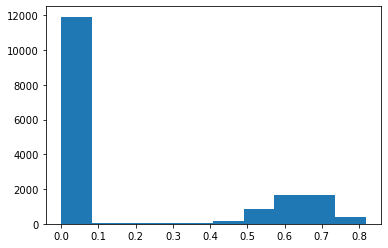

In [145]:
plt.hist(b_channel_test[0]) # Check normalization

In [140]:
train_normalized = [np.concatenate((r_channel_train[n], g_channel_train[n], b_channel_train[n])) for n in tqdm(range(len(r_channel_train)))]
test_normalized = [np.concatenate((r_channel_test[n], g_channel_test[n], b_channel_test[n])) for n in tqdm(range(len(r_channel_test)))]

100%|██████████| 1770/1770 [00:00<00:00, 2145.45it/s]


In [142]:
train_normalized[0].shape
test_normalized[0].shape

(50400,)

### PCA

In [148]:
# Apply PCA for dimensionality reduction 
# Start: 6:45pm
# End: 7:05pm
pca = PCA(n_components = 0.95) # 95% of variance 
training_pc = pca.fit_transform(train_normalized)
print(pca.explained_variance_ratio_)

[3.50771034e-01 7.94935322e-02 3.79775755e-02 3.48594234e-02
 3.32606818e-02 2.66513117e-02 2.25012918e-02 1.83682016e-02
 1.62385806e-02 1.59746987e-02 1.31631568e-02 1.17516960e-02
 1.07653586e-02 9.75550789e-03 8.69122781e-03 7.56895017e-03
 7.14501859e-03 6.95070038e-03 6.45414243e-03 6.33476377e-03
 5.72795798e-03 5.51778616e-03 5.28211293e-03 4.75866610e-03
 4.41835624e-03 4.28656286e-03 4.25955631e-03 4.02365614e-03
 3.90162503e-03 3.59479632e-03 3.43792088e-03 3.36504720e-03
 3.20824659e-03 3.17660288e-03 2.95379359e-03 2.77437887e-03
 2.68275108e-03 2.54915437e-03 2.43505067e-03 2.33909441e-03
 2.27759078e-03 2.24310581e-03 2.20440483e-03 2.14144340e-03
 2.13138509e-03 2.08197454e-03 2.01726141e-03 1.95293127e-03
 1.91101819e-03 1.84140099e-03 1.80771273e-03 1.71861940e-03
 1.67965749e-03 1.65095909e-03 1.61165066e-03 1.58814187e-03
 1.56277918e-03 1.55098116e-03 1.51339604e-03 1.49300688e-03
 1.47321617e-03 1.40928853e-03 1.36561578e-03 1.32756538e-03
 1.31525860e-03 1.293093

In [149]:
testing_pc = pca.transform(test_normalized)
testing_pc[0].shape

(368,)

## Baseline Model Training and Evaluation

In [186]:
# Run randomized search for hyperparameter tuning 
def hyperparameter_tuning(model, param_grid):
    param_search = RandomizedSearchCV(model, param_grid, random_state=0).fit(training_pc, y_train)
    return param_search.best_params_

In [172]:
# Plot confusion matrix
def plot_confusion(model, x, y, model_name):
    cm = confusion_matrix(y, model.predict(x), normalize = 'true')*100
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(model.score(x, y))
    plt.title(model_name+" Performance Across Skin Conditions", size = 15);

### Logistic Regression

In [158]:
# Train logistic regression model using optimal hyperparameters
logistic_model = LogisticRegression(max_iter = 1000, multi_class = 'multinomial', C = 0.2835648865872159, solver = 'newton-cg')

In [157]:
# Run randomized search for hyperparameter tuning 
logistic_param_grid = {"C":uniform(loc=0, scale=5), "solver":['newton-cg', 'lbfgs', 'sag', 'saga']}
log_search = RandomizedSearchCV(logistic_model, logistic_param_grid, random_state=0).fit(training_pc, y_train)
log_search.best_params_

C:\Users\wchen\.conda\envs\derm_classify\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\wchen\.conda\envs\derm_classify\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

C:\Users\wchen\.conda\envs\derm_classify\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\wchen\.conda\envs\derm_classify\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\wchen\.conda\envs\derm_classify\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\wchen\.conda\envs\derm_classify\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\wchen\.conda\envs\derm_classify\lib\site-packages\sklearn\l

{'C': 0.2835648865872159, 'solver': 'newton-cg'}

In [159]:
logistic_model.fit(training_pc, y_train)
# {'C': 2.195254015709299, 'solver': 'lbfgs'}

LogisticRegression(C=0.2835648865872159, max_iter=1000,
                   multi_class='multinomial', solver='newton-cg')

In [160]:
print("Accuracy on test set: "+str(logistic_model.score(testing_pc, y_test)))
print("AUC Score: "+ str(roc_auc_score(y_test, logistic_model.predict_proba(testing_pc), multi_class='ovr')))

Accuracy on test set: 0.2632768361581921
AUC Score: 0.5440702802898069


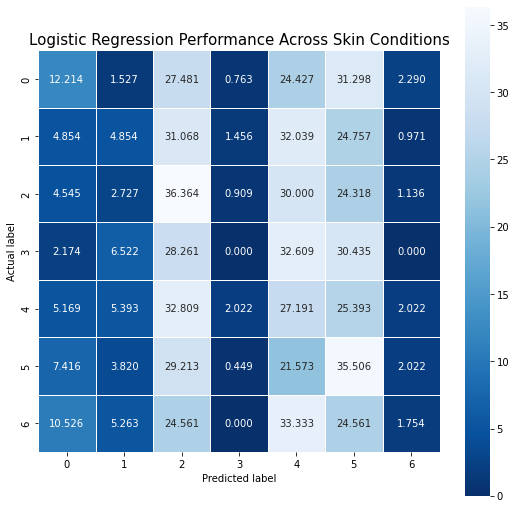

In [168]:
plot_confusion(logistic_model, testing_pc, y_test)

### Support Vector Machine

In [182]:
# Support Vector Classifier Training
svc_model = SVC()

In [ ]:
# Run randomized search for hyperparameter tuning 
svc_param_grid = {"C":uniform(loc=0, scale=5), "kernel":['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], 
                  "shrinking":[True, False]}
svc_search = RandomizedSearchCV(svc_model, svc_param_grid, random_state=0).fit(x_train, y_train)
svc_search.best_params_

In [183]:
svc_model.fit(training_pc, y_train)

SVC()

In [184]:
print(svc_model.score(testing_pc, y_test))
print("AUC Score: "+ str(roc_auc_score(y_test, rf_model.predict_proba(testing_pc), multi_class='ovr')))

0.29887005649717513
AUC Score: 0.5428824162418181


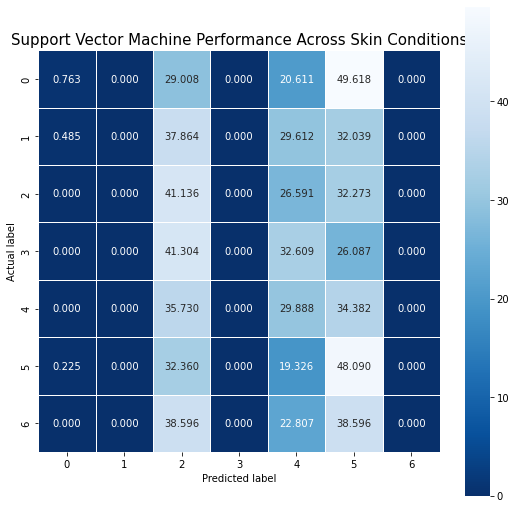

In [185]:
plot_confusion(svc_model, testing_pc, y_test, "Support Vector Machine")

### Random Forest

In [228]:
# Random Forest Training
rf_model = RandomForestClassifier()
rf_model.fit(training_pc, y_train)

In [ ]:
rf_param_grid = {"n_estimators":[n for n in range(1, 500)], "max_depth":["None"]+[n for n in range(1, 50)], 
                 "criterion":["gini", "entropy", "log_loss"], "min_samples_split":[n for n in range(2, 11)],
                 "min_samples_leaf":[n for n in range(1, 11)], "max_features":["sqrt", "log2", None]}
rf_search = hyperparameter_tuning(rf_model, rf_param_grid)
print(rf_search)

In [171]:
#rf_model.score(x_test, y_test)
print("Accuracy on test set: "+str(rf_model.score(testing_pc, y_test)))
print("AUC Score: "+ str(roc_auc_score(y_test, rf_model.predict_proba(testing_pc), multi_class='ovr')))

Accuracy on test set: 0.2740112994350282
AUC Score: 0.5428824162418181


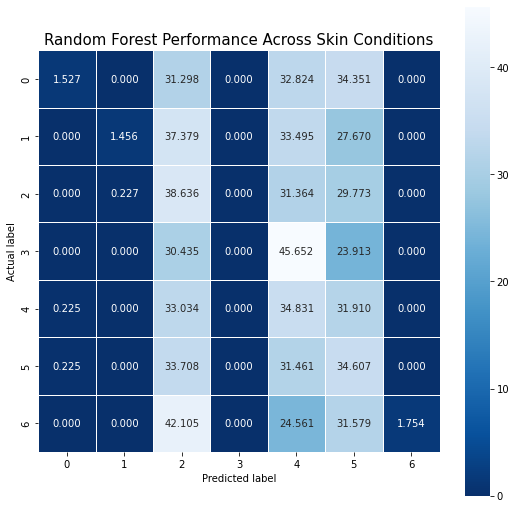

In [173]:
plot_confusion(rf_model, testing_pc, y_test, "Random Forest")

### Multi-Layer Perceptron

In [179]:
# Train multi-layer perceptron
mlp_model = MLPClassifier(max_iter=1000)
mlp_model.fit(training_pc, y_train)

MLPClassifier(max_iter=1000)

In [ ]:
# Run randomized search for hyperparameter tuning 
mlp_param_grid = {"C":uniform(loc=0, scale=5), "kernel":['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], 
                  "shrinking":[True, False]}
mlp_search = RandomizedSearchCV(svc_model, svc_param_grid, random_state=0).fit(x_train, y_train)
mlp_search.best_params_

In [180]:
print(mlp_model.score(testing_pc, y_test))
print("AUC Score: "+ str(roc_auc_score(y_test, mlp_model.predict_proba(testing_pc), multi_class='ovr')))

0.24067796610169492
AUC Score: 0.5476263255858539


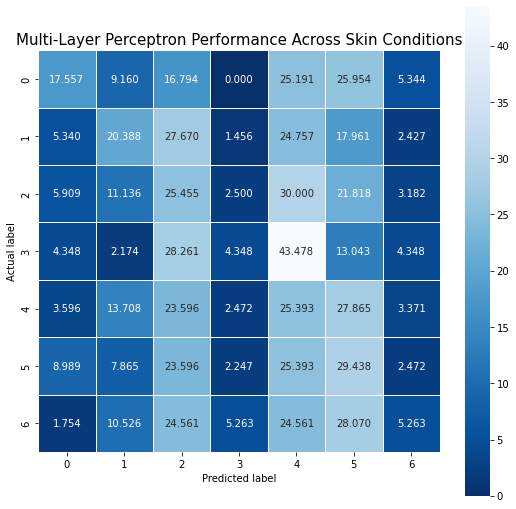

In [181]:
plot_confusion(mlp_model, testing_pc, y_test, "Multi-Layer Perceptron")

### K-Nearest Neighbors

In [226]:
# Knn
knn = KNeighborsClassifier(n_neighbors=89, weights = 'distance')
knn.fit(training_pc, y_train)
print(knn.score(testing_pc, y_test))
print("AUC Score: "+ str(roc_auc_score(y_test, knn.predict_proba(testing_pc), multi_class='ovr')))

0.30338983050847457
AUC Score: 0.5709131546009224


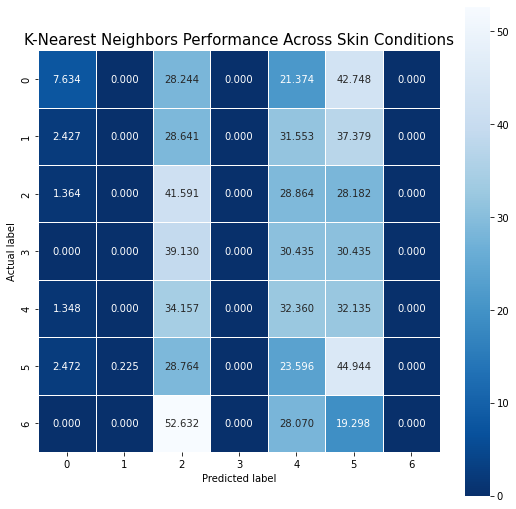

In [223]:
plot_confusion(knn, testing_pc, y_test, "K-Nearest Neighbors")

### Gradient Boosting

In [177]:
# Gradient boosting
grad_boost = GradientBoostingClassifier().fit(training_pc, y_train)
print(grad_boost.score(testing_pc, y_test))
print("AUC Score: "+ str(roc_auc_score(y_test, grad_boost.predict_proba(testing_pc), multi_class='ovr')))

0.27175141242937856
AUC Score: 0.5710533859003231


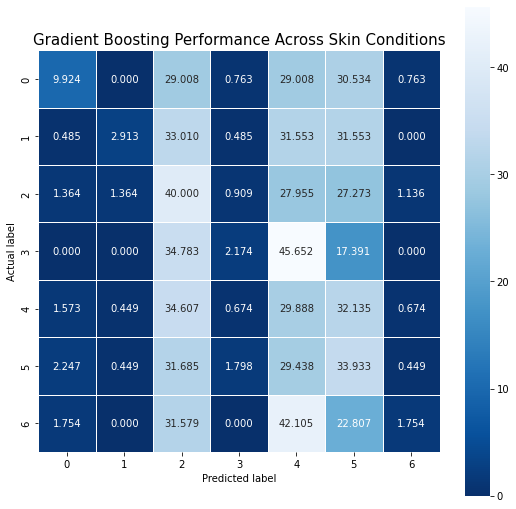

In [178]:
plot_confusion(grad_boost, testing_pc, y_test, "Gradient Boosting")